In [ ]:
from act.cell_model import TargetCell, TrainCell
from act.simulator import Simulator
from act.act_types import SimulationParameters
# /Users/vladimiromelyusik/ACT/data/Burster/Izhikevich_p307_orig/template.hoc
# /Users/vladimiromelyusik/ACT/data/Burster/Izhikevich_p307_orig/modfiles
hoc_file = "/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_orig/template.hoc"
mod_folder = "/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_orig/modfiles"

### 1. Generate target data

In [ ]:
# Init the cell
target_cell = TargetCell(
    hoc_file = hoc_file,
    mod_folder= mod_folder,
    cell_name = "Burster_Izh",
    g_names = ["gbar_nap", "gkdrbar_kdr", "gbar_na3", "gmbar_im", "glbar_leak"]
)

current_intensities = [0.1, 0.2, 0.3]

In [ ]:
# Simulate voltage traces
simulator = Simulator()
for i, intensity in enumerate(current_intensities):
    simulator.submit_job(
        target_cell,
        SimulationParameters(
            sim_name = "target1",
            sim_idx=i,
            h_v_init = -70, # (mV)
            h_tstop = 300,  # (ms)
            h_dt = 0.01, # (ms)
            h_celsius = 37, # (deg C)
            CI = {
                "type": "constant",
                "amp": intensity,
                "dur": 290,
                "delay": 10
            }
        )
    )

In [ ]:
# Run
simulator.run(mod_folder)

from act.DataProcessor import DataProcessor
dp = DataProcessor()
dp.combine_data("./model/target1")

In [ ]:
import numpy as np
from act.DataProcessor import DataProcessor
dataset = np.load("./model/target1/combined_out.npy")

dp = DataProcessor()
g = dp.clean_g_bars(dataset)

#print(dataset[:,:,1])
#print(g)

### 2. Generate simulated data

#### Get Passive Properties

In [ ]:
# Predict passive properties
from act.DataProcessor import DataProcessor
from act.cell_model import TrainCell, TargetCell
import matplotlib.pyplot as plt
import numpy as np


# Simulate a negative current injection and get all of the data needed to calculate the passive properties.
# This is a stand in for voltage data provided by the user.
dp = DataProcessor()
(
V,
dt, 
h_tstop, 
I_tstart, 
I_intensity,
cell_area
) = dp.simulate_negative_CI(target_cell, "glbar_leak")

plt.plot(V)

dp = DataProcessor()
props = dp.calculate_passive_properties(V, dt,h_tstop,I_tstart,I_intensity,cell_area,"glbar_leak")

print(props)

In [ ]:
from act.cell_model import TrainCell

# Init the cell
train_cell = TrainCell(
    hoc_file = hoc_file,
    mod_folder= mod_folder,
    cell_name = "Burster_Izh",
    g_names = ["gbar_nap", "gkdrbar_kdr", "gbar_na3", "gmbar_im", "glbar_leak"]
)

channel_ranges = [
    (0.0001, 0.0006),  
    (0.01, 0.056),
    (0.01, 0.06),
    (0.00066667, 0.0033),
    (props['g_bar_leak'],props['g_bar_leak']) # We know this conductance
]
channel_samples = [3, 3, 2, 3, 1]
#current_intensities = [0.1, 0.2, 0.3] # same as target_cell. comment out if wanting one control spot
conductance_groups, current_settings = dp.generate_I_g_combinations(channel_ranges, channel_samples, current_intensities)

In [ ]:
print(len(conductance_groups))
print(conductance_groups[0])
print(conductance_groups[71])

In [ ]:
# Simulate voltage traces
simulator = Simulator()

for i in range(len(conductance_groups)):
        # Set parameters from the grid
        train_cell.set_g(["gbar_nap", "gkdrbar_kdr", "gbar_na3", "gmbar_im", "glbar_leak"], conductance_groups[i])
        simulator.submit_job(
            train_cell, 
            SimulationParameters(
                sim_name = "train1",
                sim_idx = i,
                h_v_init = -70, # (mV)
                h_tstop = 300,  # (ms)
                h_dt = 0.01, # (ms)
                h_celsius = 37, # (deg C)
                CI = {
                    "type": "constant",
                    "amp": current_settings[i],
                    "dur": 290,
                    "delay": 10
                }
            )
        )

In [ ]:
# Run
simulator.run(mod_folder)

from act.DataProcessor import DataProcessor
dp = DataProcessor()
dp.combine_data("./model/train1")

In [ ]:
# MatchFilter will go over saved data and create a dataset of the traces that match,
# deleting others

## 3. Train the model

In [1]:
import numpy as np
from act.DataProcessor import DataProcessor
dataset_train = np.load("./model/train1/combined_out.npy")

dp = DataProcessor()
g_train = dp.clean_g_bars(dataset_train)
V_train = dataset_train[:,:,0]
I_train = dataset_train[:,:,1]

# need in documentation list_of_features
# ["i_mean_stdev", "v_spike_stats", "v_mean_potential", "v_amplitude_frequency", "v_arima_coefs"]
features_train, columns_train = dp.extract_features(V=V_train,I=I_train,inj_dur=290,inj_start=10)

print(f"columns_train: {columns_train}")
print(features_train.shape)

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)


  0%|          | 0/162 [00:00<?, ?it/s]/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameter

columns_train: ['I_mean', 'I_stdev', 'Num Spikes', 'Interspike Interval', 'Avg Min Spike Height', 'Avg Max Spike Height', 'V_mean', 'amplitude', 'frequency', 'arima0', 'arima1', 'arima2', 'arima3', 'arima4', 'arima5', 'arima6', 'arima7', 'arima8', 'arima9']
(162, 19)


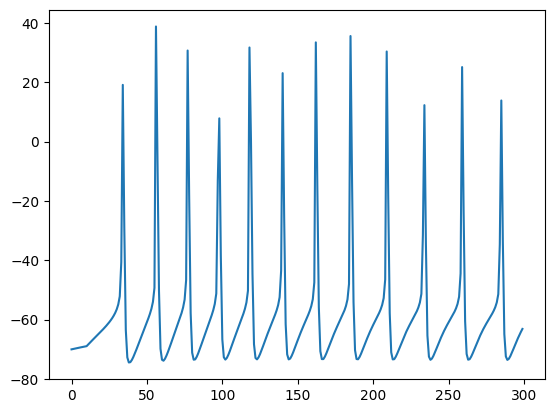

In [2]:
import matplotlib.pyplot as plt
#print(V_train[20])
plt.plot(V_train[-1])
plt.show()

In [3]:
import numpy as np
from act.DataProcessor import DataProcessor
dataset_target = np.load("./model/target1/combined_out.npy")

dp = DataProcessor()
g_target = dp.clean_g_bars(dataset_target)
V_target = dataset_target[:,:,0]
I_target = dataset_target[:,:,1]

features_target, columns_target = dp.extract_features(V=V_target,I=I_target,inj_dur=290,inj_start=10)

print(f"columns_tar: {columns_target}")
print(features_target.shape)

-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)


  0%|          | 0/3 [00:00<?, ?it/s]/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mwsrgf/act-venv/lib64/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

columns_tar: ['I_mean', 'I_stdev', 'Num Spikes', 'Interspike Interval', 'Avg Min Spike Height', 'Avg Max Spike Height', 'V_mean', 'amplitude', 'frequency', 'arima0', 'arima1', 'arima2', 'arima3', 'arima4', 'arima5', 'arima6', 'arima7', 'arima8', 'arima9']
(3, 19)


In [4]:
# Fitting Random Forest
from act.optimizer import RandomForestOptimizer

X_train = features_train
Y_train = g_train

print(X_train.shape)
print(Y_train.shape)

rf = RandomForestOptimizer()
rf.fit(X_train, Y_train)

(162, 19)
(162, 5)


In [5]:
# Evaluate the model's accuracy
from act.Metrics import Metrics

metrics = Metrics()

metrics.evaluate_random_forest(rf.model, X_train, Y_train)

Evaluating random forest
MAE: 0.002633 (0.000607)


In [7]:
X_test = features_target
prediction = rf.predict(X_test)

print(prediction.shape)
print(prediction)

(3, 5)
[[1.19000000e-04 2.79400000e-02 1.34000000e-02 2.59690089e-03
  3.50000295e-05]
 [3.48250000e-04 2.83770000e-02 2.23500000e-02 2.15186812e-03
  3.50000295e-05]
 [4.29750000e-04 2.14770000e-02 5.99500000e-02 3.02745034e-03
  3.50000295e-05]]


In [ ]:
# CA3, passive, spiking, bursting